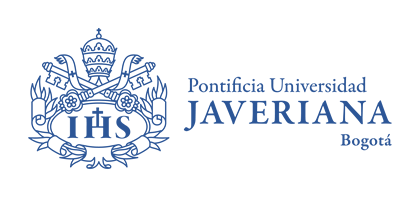

# **Segunda entrega del proyecto - Procesamiento de Lenguaje Natural**

### **Realizado por:**

- Sebastián Herrera
- Carlos Másmela
- Yuddy Pedraza

### **Resumen:**

El siguiente Notebook tiene como propósito mostrar una solución al problema de **clasificación** de la búsqueda de canciones con el modelo **Modelos Clásicos - Léxico**. Se aclara que para pode realizar lo anterior fue necesario un preprocesamiento y limpieza de la data.

# **Librerias**

In [2]:
!pip install transformers --quiet
!pip install transformers datasets --quiet
!pip install transformers[torch] --quiet
!pip install evaluate --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import torch
import transformers
from sklearn.model_selection import train_test_split

# **Lectura de data**

In [5]:
ruta = "data.csv" #../../../../data/data_processed/data.csv"
data = pd.read_csv(ruta)
data.head()

,Genero,Artista,Titulo,Cancion
0,pop,Shakira,Waka Waka (Esto Es África),"Llegó el momento, caen las murallas\r\nVa a co..."
1,pop,Shakira,Gitana,Nunca usé un antifaz\r\nVoy de paso por este m...
2,pop,Shakira,"Te Aviso, Te Anuncio (Tango)",Nunca pensé que doliera el amor así\r\nCuando ...
3,pop,Shakira,Addicted To You,Debe ser el perfume que usas\r\nO el agua con ...
4,pop,Shakira,Monotonía (part. Ozuna),"No fue culpa tuya, ni tampoco mía\r\nFue culpa..."


Se observan nulos

In [6]:
data.isnull().sum()

Genero     0
Artista    0
Titulo     1
Cancion    2
dtype: int64

Se remueven nulos ya que son muy pocos.

In [7]:
data = data.dropna()

Se vuelve a revisar si se tiene nulos

In [8]:
data.isnull().sum()

Genero     0
Artista    0
Titulo     0
Cancion    0
dtype: int64

# **Preparacion de la data**

Separacion de X y y

In [9]:
X = data["Cancion"]
y = data["Genero"].map(
    {"pop": 0, "reggaeton": 1, "rock": 2, "vallenato": 3, "salsa": 4}
)

Se ve si las clases están balanceadas

In [10]:
y.value_counts()

0    640
2    626
1    600
3    600
4    599
Name: Genero, dtype: int64

Se presenta modelo balanceado que hace que sea más fácil entrenar el modelo.

# ***Método \#1***

Se se empleará los embeddings de ``DistilBert`` para entrenar modelos clásicos

## **Cargue del Modelo**

Se aplicará DistilBERT para poder ejecutar el modelo.

In [ ]:
#Se importa DistilBERT
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel, transformers.DistilBertTokenizer, 'distilbert-base-uncased')

# Se carga modelo pre-entrenado y tokenizador pre-entrenado
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

## **Generacion de los embeddings**

Convertir los textos en palabras que DistilBERT pueda entender. Es decir, realiza:
- Lectura de data.
- Separación de palabras.
- Agrega palabras especiales [CLS], [SEP], entre otros.
- Transforma al ID correspondiente

In [ ]:
tokenized = X.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors


Habiendo generado los tokens se procede a hacer que BERT corra todas las muestras de una sola corrida, es por eso que debe hacerse que todas las filas que se tienen queden del mismo tamaño. Para ello se realiza **Padding** para hacer que quede una matriz de la cantidad de filas que hay y las columnas como la cantidad maxima de sentencia encontrada.

In [ ]:
#Se busca el máximo valor entre todas las filas
max_len = 0
for fila in tokenized.values:
    if len(fila) > max_len:
        max_len = len(fila)

#Se aplica padding para que todos los vectores queden de este tamaño, agregando ceros a lo que falta para llegar
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

#Nuevo shape
np.array(padded).shape

(3065, 3085)

In [ ]:
padded = np.delete(padded, range(100, 3085), axis=1)
padded.shape

(3065, 100)

Debido a que se realizo el **padding** debemos indicarle a BERT donde realizar la atención determinada, es por esto que se genera un **mask** para poder solucionar esto.

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(3065, 100)

## **Ejecutar el modelo**

``model`` corre nuestras canciones en el modelo pre-entrenado DistilBERT y se guarda la salida en ``last_hidden_state``

In [ ]:
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

## Generación de X_train y y_train para este caso

Se ponen las soluciones del embedding dentro de una variable ``features`` y la variable a predecir en ``labels``

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()

In [ ]:
labels = y

Se divide la data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels)

## **Regresión Logística**

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
lr_clf.score(X_test, y_test)

0.5097783572359843

## XGBoost

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
xgb.score(X_test, y_test)

0.49674054758800523

# ***Método \#2***

Se empleará ``DistilBert`` en dos escenarios.
- El primero es poner todo el texto en minúscula.
- El segundo es dejar el texto tal cual está.

A continuación se presentan los dos

## *DistilBERT con sólo minúsculas*

### **Preparación de la data**

#### *Generación de DatasetDict*

In [ ]:
from datasets import Dataset, DatasetDict, Features, ClassLabel, Value

Generación del dataset

In [ ]:
dataset = pd.DataFrame(columns=["text", "labels"])
dataset["text"] = X.str.lower().to_list() #minusculas
dataset["labels"] = y.to_list()

División de data en train, validación, test

In [ ]:
#train, validation, test = np.split(dataset.sample(frac=1, random_state=42), [int(0.8 * len(dataset)), int(0.9 * len(dataset))])

In [ ]:
train, test = np.split(dataset.sample(frac=1, random_state=42), [int(0.8 * len(dataset))])

Se crean caracteristicas y etiquetas

In [ ]:
features = Features({
    'text': Value(dtype='string'),
    'labels': ClassLabel(num_classes=5, names=[0, 1, 2, 3, 4])
})

Se reinician index

In [ ]:
train.reset_index(drop=True, inplace=True)
#validation.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

Se crea diccionario de HuggingFace

In [ ]:
train_dataset = Dataset.from_pandas(train, features=features)
#val_dataset = Dataset.from_pandas(validation, features=features)
test_dataset = Dataset.from_pandas(test, features=features)

dataset_dict_musical = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

In [ ]:
dataset_dict_musical

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 2452
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 613
    })
})

#### *Preparar el dataset*

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased') #'distilbert-base-uncased' o "bert-base-cased"


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = dataset_dict_musical.map(tokenize_function, batched=True)

Map:   0%|          | 0/2452 [00:00<?, ? examples/s]

Map:   0%|          | 0/613 [00:00<?, ? examples/s]

### **Crear DistilBERT**

Este modelo es con solo minusculas

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5) #'distilbert-base-uncased' o "bert-base-cased"

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

### **Entrenando DistilBERT**

Este modelo es con solo minusculas

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.142726,0.515498
2,1.218000,0.868758,0.670473
3,1.218000,0.816994,0.685155


TrainOutput(global_step=921, training_loss=1.0168672079113226, metrics={'train_runtime': 411.5521, 'train_samples_per_second': 17.874, 'train_steps_per_second': 2.238, 'total_flos': 974482317250560.0, 'train_loss': 1.0168672079113226, 'epoch': 3.0})

## *DistilBERT con data original*

### **Preparación de la data**

#### *Generación de DatasetDict*

In [ ]:
from datasets import Dataset, DatasetDict, Features, ClassLabel, Value

Generación del dataset

In [ ]:
dataset = pd.DataFrame(columns=["text", "labels"])
dataset["text"] = X.to_list() #data original
dataset["labels"] = y.to_list()

División de data en train, validación, test

In [ ]:
#train, validation, test = np.split(dataset.sample(frac=1, random_state=42), [int(0.8 * len(dataset)), int(0.9 * len(dataset))])

In [ ]:
train, test = np.split(dataset.sample(frac=1, random_state=42), [int(0.8 * len(dataset))])

Se crean caracteristicas y etiquetas

In [ ]:
features = Features({
    'text': Value(dtype='string'),
    'labels': ClassLabel(num_classes=5, names=[0, 1, 2, 3, 4])
})

Se reinician index

In [ ]:
train.reset_index(drop=True, inplace=True)
#validation.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

Se crea diccionario de HuggingFace

In [ ]:
train_dataset = Dataset.from_pandas(train, features=features)
#val_dataset = Dataset.from_pandas(validation, features=features)
test_dataset = Dataset.from_pandas(test, features=features)

dataset_dict_musical = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

In [ ]:
dataset_dict_musical

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 2452
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 613
    })
})

#### *Preparar el dataset*

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased') #'distilbert-base-uncased' o "bert-base-cased"


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = dataset_dict_musical.map(tokenize_function, batched=True)

Map:   0%|          | 0/2452 [00:00<?, ? examples/s]

Map:   0%|          | 0/613 [00:00<?, ? examples/s]

### **Crear DistilBERT**

Este modelo es con data original

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5) #'distilbert-base-uncased' o "bert-base-cased"

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

### **Entrenando DistilBERT**

Este modelo es con data original

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.088920,0.579119
2,1.208600,0.834056,0.701468
3,1.208600,0.781461,0.712887


TrainOutput(global_step=921, training_loss=0.9904267914779282, metrics={'train_runtime': 418.0809, 'train_samples_per_second': 17.595, 'train_steps_per_second': 2.203, 'total_flos': 974482317250560.0, 'train_loss': 0.9904267914779282, 'epoch': 3.0})

# **Método \#3**

Se correrá ``BERT`` con el fin de poder obtener la mejor solución posible

## *BERT uncased*

### **Preparación de la data**

#### *Generación de DatasetDict*

In [ ]:
from datasets import Dataset, DatasetDict, Features, ClassLabel, Value

Generación del dataset

In [ ]:
dataset = pd.DataFrame(columns=["text", "labels"])
dataset["text"] = X.to_list()
dataset["labels"] = y.to_list()

División de data en train, validación, test

In [ ]:
#train, validation, test = np.split(dataset.sample(frac=1, random_state=42), [int(0.8 * len(dataset)), int(0.9 * len(dataset))])

In [ ]:
train, test = np.split(dataset.sample(frac=1, random_state=42), [int(0.8 * len(dataset))])

Se crean caracteristicas y etiquetas

In [ ]:
features = Features({
    'text': Value(dtype='string'),
    'labels': ClassLabel(num_classes=5, names=[0, 1, 2, 3, 4])
})

Se reinician index

In [ ]:
train.reset_index(drop=True, inplace=True)
#validation.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

Se crea diccionario de HuggingFace

In [ ]:
train_dataset = Dataset.from_pandas(train, features=features)
#val_dataset = Dataset.from_pandas(validation, features=features)
test_dataset = Dataset.from_pandas(test, features=features)

dataset_dict_musical = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

In [ ]:
dataset_dict_musical

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 2452
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 613
    })
})

#### *Preparar el dataset*

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased') #'distilbert-base-uncased' o "bert-base-cased"


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = dataset_dict_musical.map(tokenize_function, batched=True)

Map:   0%|          | 0/2452 [00:00<?, ? examples/s]

Map:   0%|          | 0/613 [00:00<?, ? examples/s]

### **Crear BERT**

Este modelo es el original

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5) #'distilbert-base-uncased' o "bert-base-cased"

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

### **Entrenando BERT**

Este modelo es el original

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.625417,0.181077
2,1.632200,1.617276,0.223491
3,1.632200,1.615404,0.181077


TrainOutput(global_step=921, training_loss=1.6251149793660085, metrics={'train_runtime': 772.0263, 'train_samples_per_second': 9.528, 'train_steps_per_second': 1.193, 'total_flos': 1935497055965184.0, 'train_loss': 1.6251149793660085, 'epoch': 3.0})

## *BERT cased*

### **Preparación de la data**

#### *Generación de DatasetDict*

In [12]:
from datasets import Dataset, DatasetDict, Features, ClassLabel, Value

Generación del dataset

In [13]:
dataset = pd.DataFrame(columns=["text", "labels"])
dataset["text"] = X.to_list()
dataset["labels"] = y.to_list()

División de data en train, validación, test

In [14]:
#train, validation, test = np.split(dataset.sample(frac=1, random_state=42), [int(0.8 * len(dataset)), int(0.9 * len(dataset))])

In [15]:
train, test = np.split(dataset.sample(frac=1, random_state=42), [int(0.8 * len(dataset))])

Se crean caracteristicas y etiquetas

In [16]:
features = Features({
    'text': Value(dtype='string'),
    'labels': ClassLabel(num_classes=5, names=[0, 1, 2, 3, 4])
})

Se reinician index

In [17]:
train.reset_index(drop=True, inplace=True)
#validation.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

Se crea diccionario de HuggingFace

In [18]:
train_dataset = Dataset.from_pandas(train, features=features)
#val_dataset = Dataset.from_pandas(validation, features=features)
test_dataset = Dataset.from_pandas(test, features=features)

dataset_dict_musical = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

In [19]:
dataset_dict_musical

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 2452
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 613
    })
})

#### *Preparar el dataset*

In [20]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased') #'distilbert-base-uncased' o "bert-base-cased"


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = dataset_dict_musical.map(tokenize_function, batched=True)

Map:   0%|          | 0/2452 [00:00<?, ? examples/s]

Map:   0%|          | 0/613 [00:00<?, ? examples/s]

### **Crear BERT**

Este modelo es el original

In [21]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=5) #'distilbert-base-uncased' o "bert-base-cased"

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

In [23]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [24]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [25]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

### **Entrenando BERT**

Este modelo es el original

In [26]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

In [27]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.344893,0.420881
2,1.446700,1.152190,0.531811
3,1.446700,1.071995,0.562806


TrainOutput(global_step=921, training_loss=1.3138531779103895, metrics={'train_runtime': 829.3775, 'train_samples_per_second': 8.869, 'train_steps_per_second': 1.11, 'total_flos': 1935497055965184.0, 'train_loss': 1.3138531779103895, 'epoch': 3.0})